In [1]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
from navigation_mdp.plotting import NavGridViewPlotter as NvPlotter
from navigation_mdp.plotting import *
# RL utils
import rl.planning as Plan
import rl.policy as Policy
from rl.model import RewardLinear, RewardConvFCAE
from irl.mlirl.mlirl import run_mlirl
# Utils
from utils.utils import *
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

## Gridworld 5x7 with image features

In [2]:
cifar = torchvision.datasets.CIFAR100(root="../datasets/", download=True)
X, y = cifar.data, np.asarray(cifar.targets)
classes = np.unique(y)
n_classes = len(classes)

print(X.shape, y.shape)

Files already downloaded and verified
(50000, 32, 32, 3) (50000,)


In [3]:
print(cifar.classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [4]:
cifar.classes.index("sunflower")

82

## Using Discrete State Space 
(a bit low level APIs)

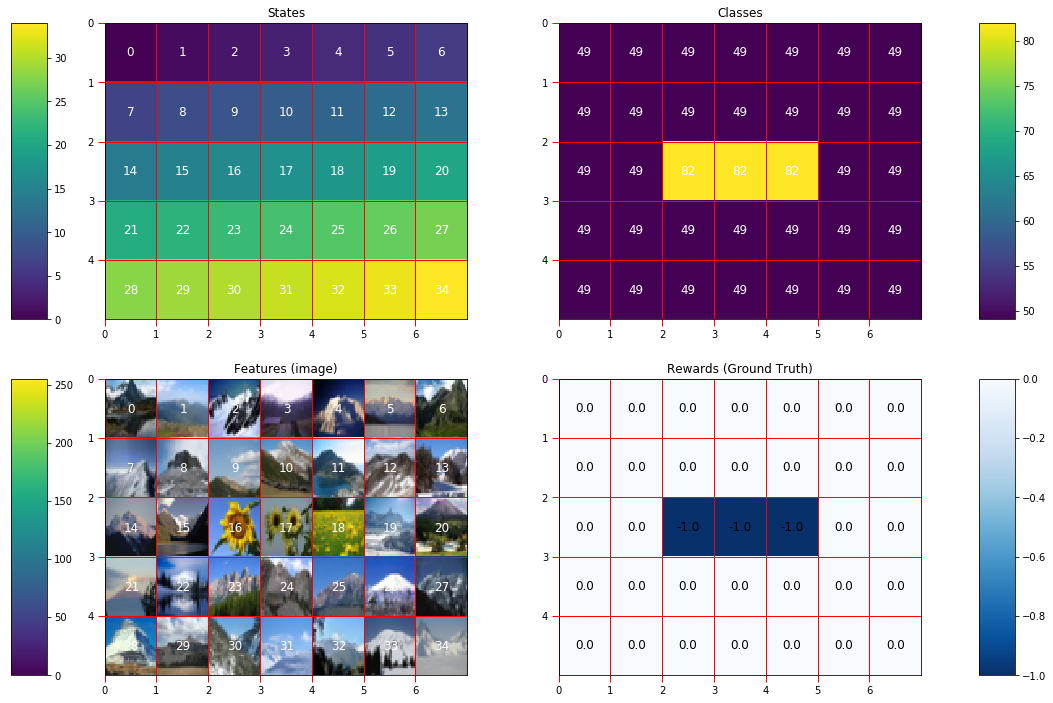

In [5]:
np.random.seed(1)
# Specify state space
S = NvMDP.state.DiscreteStateSpace(5,7)
goal_loc = (2,6)
# Attach classes
class_ids = NvMDP.class_.XYClassDistribution([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], 
    marker_to_class_id = {0: 49, 1: 82})().flatten()
S.attach_classes(class_ids)
# Attach features
S.attach_feature_spec(NvMDP.features.FeatureClassImageSampler(lambda x: sample_image(X, y, x)))
# Attach rewards
S.attach_reward_spec(NvMDP.reward.RewardStateScalar(
    loc_to_reward_dict={goal_loc: 0.}, class_id_to_reward_dict={82: -1}, default=0))
R = S.rewards()
# Specify dynamics
T = NvMDP.dynamics.XYDynamics(S, slip_prob=0.)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (image)").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,4)
NvPlotter(S).plot_rewards(
    cmap=cm.Blues_r, title="Rewards (Ground Truth)").colorbar(where="right", pad=0.8, size="10%").grid()

RewardConvFCAE(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (sigmoid): Sigmoid()
  (fc_reward): Linear(in_features=64, out_features=1, bias=False)
  (t_fc2): Linear(in_features=64, out_features=128, bias=True)
  (t_fc1): Linear(in_features=128, out_features=1024, bias=True)
  (t_conv2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv1): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


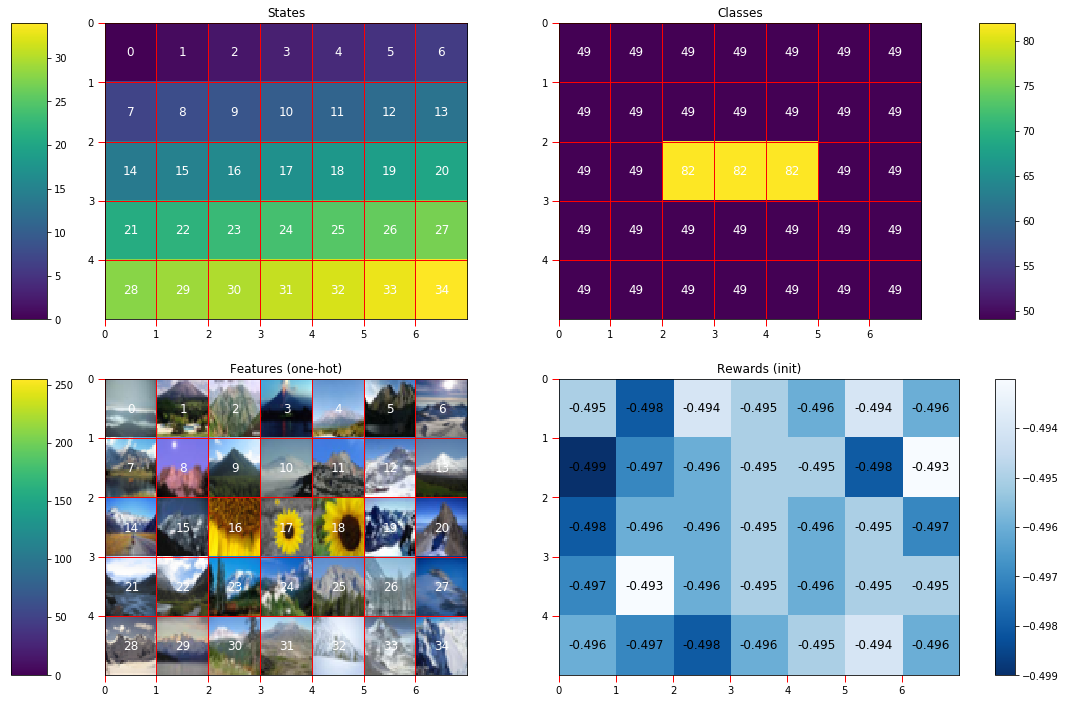

In [6]:
PHI = torch.FloatTensor(S.features()).permute(0,3,1,2) / 255.
R_model = RewardConvFCAE(PHI[0].shape, fc1_in=1024, lr=0.005, weight_decay=0.)
print(R_model)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (one-hot)").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,4)
NvPlotter(S).plot_array(R_model(PHI).detach().numpy().round(3), 
                           cmap=cm.Blues_r, title="Rewards (init)").colorbar(where="right", pad=0.5)

In [7]:
# # T.ACTIONS: ['U', 'D', 'L', 'R']
# Sk = S.at_loc((2,2))
# Ak = "U"
goal = S.at_loc((2,6))
log_likelihoods_history = []
s_lst_lst = [[(2,0), (2,1), (1,1), (1,2), (1,3), (1,4), (1,5), (2,5), (2,6)], 
            [(2,0), (2,1), (3,1), (3,2), (3,3), (3,4), (3,5), (2,5), (2,6)]]
a_lst_lst = [["R", "U", "R", "R", "R", "R", "D", "R", None],
              ["R", "D", "R", "R", "R", "R", "U", "R", None]]

for _iter in range(120):
    
    _iter_start_time = time.time()
    R_model.zero_grad()
    VI = Plan.ValueIteration(S, R_model(PHI), T, verbose=True, log_pi=False, gamma=0.99, goal=goal)
    VI.run(100, lambda q: Policy.Boltzmann(q, boltzmann_temp=.1), reasoning_iters=50, 
           verbose=True, debug=False, eps=1e-6)
    
    for k in range(len(s_lst_lst)):
        loss = 0
        for i in range(len(s_lst_lst[k])-1):
            loss += -torch.log(VI.Pi[VI.get_tbl_idxs(S.at_loc(s_lst_lst[k][i]), a_lst_lst[k][i])])
    #         print(Pi[VI.get_tbl_idxs(S.at_loc((2,1+i)), "R")], loss)
    ll = np.exp(-loss.detach().item())
    log_likelihoods_history.append(ll)
    
    print("\n>>> Iter: {:04d} ({:03.3f}s): loss = {:09.6f}, likelihood = {:02.4f}\n\n".format(
                    _iter, time.time()-_iter_start_time, loss, ll))
    loss.backward()
    R_model.step()

Setting goal as terminal state!
Learning values [  0 ] Converged @ 12.
Reasoning [  12 42 61 ] Done (50 iters).

>>> Iter: 0000 (1.061s): loss = 13.277616, likelihood = 0.0000


Learning values [  0 ] Converged @ 14.
Reasoning [  14 44 63 ] Done (50 iters).

>>> Iter: 0001 (1.087s): loss = 11.478531, likelihood = 0.0000


Learning values [  0 ] Converged @ 17.
Reasoning [  17 47 66 ] Done (50 iters).

>>> Iter: 0002 (1.049s): loss = 06.930389, likelihood = 0.0010


Learning values [  0 ] Converged @ 18.
Reasoning [  18 48 67 ] Done (50 iters).

>>> Iter: 0003 (1.073s): loss = 04.744676, likelihood = 0.0087


Learning values [  0 ] Converged @ 18.
Reasoning [  18 48 67 ] Done (50 iters).

>>> Iter: 0004 (1.114s): loss = 03.884913, likelihood = 0.0205


Learning values [  0 ] Converged @ 19.
Reasoning [  19 49 68 ] Done (50 iters).

>>> Iter: 0005 (1.108s): loss = 01.641620, likelihood = 0.1937


Learning values [  0 ] Converged @ 13.
Reasoning [  13 43 62 ] Done (50 iters).

>>> Iter: 0

Learning values [  0 30 49 ] Stopped @ 50.
Reasoning [  50 80 99 ] Done (50 iters).

>>> Iter: 0056 (1.466s): loss = 00.026868, likelihood = 0.9735


Learning values [  0 ] Converged @ 24.
Reasoning [  24 54 73 ] Done (50 iters).

>>> Iter: 0057 (1.171s): loss = 00.025269, likelihood = 0.9750


Learning values [  0 ] Converged @ 23.
Reasoning [  23 53 72 ] Done (50 iters).

>>> Iter: 0058 (1.163s): loss = 00.023203, likelihood = 0.9771


Learning values [  0 ] Converged @ 24.
Reasoning [  24 54 73 ] Done (50 iters).

>>> Iter: 0059 (1.153s): loss = 00.022000, likelihood = 0.9782


Learning values [  0 ] Converged @ 23.
Reasoning [  23 53 72 ] Done (50 iters).

>>> Iter: 0060 (1.134s): loss = 00.022200, likelihood = 0.9780


Learning values [  0 30 49 ] Stopped @ 50.
Reasoning [  50 80 99 ] Done (50 iters).

>>> Iter: 0061 (1.446s): loss = 00.023131, likelihood = 0.9771


Learning values [  0 ] Converged @ 23.
Reasoning [  23 53 72 ] Done (50 iters).

>>> Iter: 0062 (1.151s): loss = 00.

KeyboardInterrupt: 

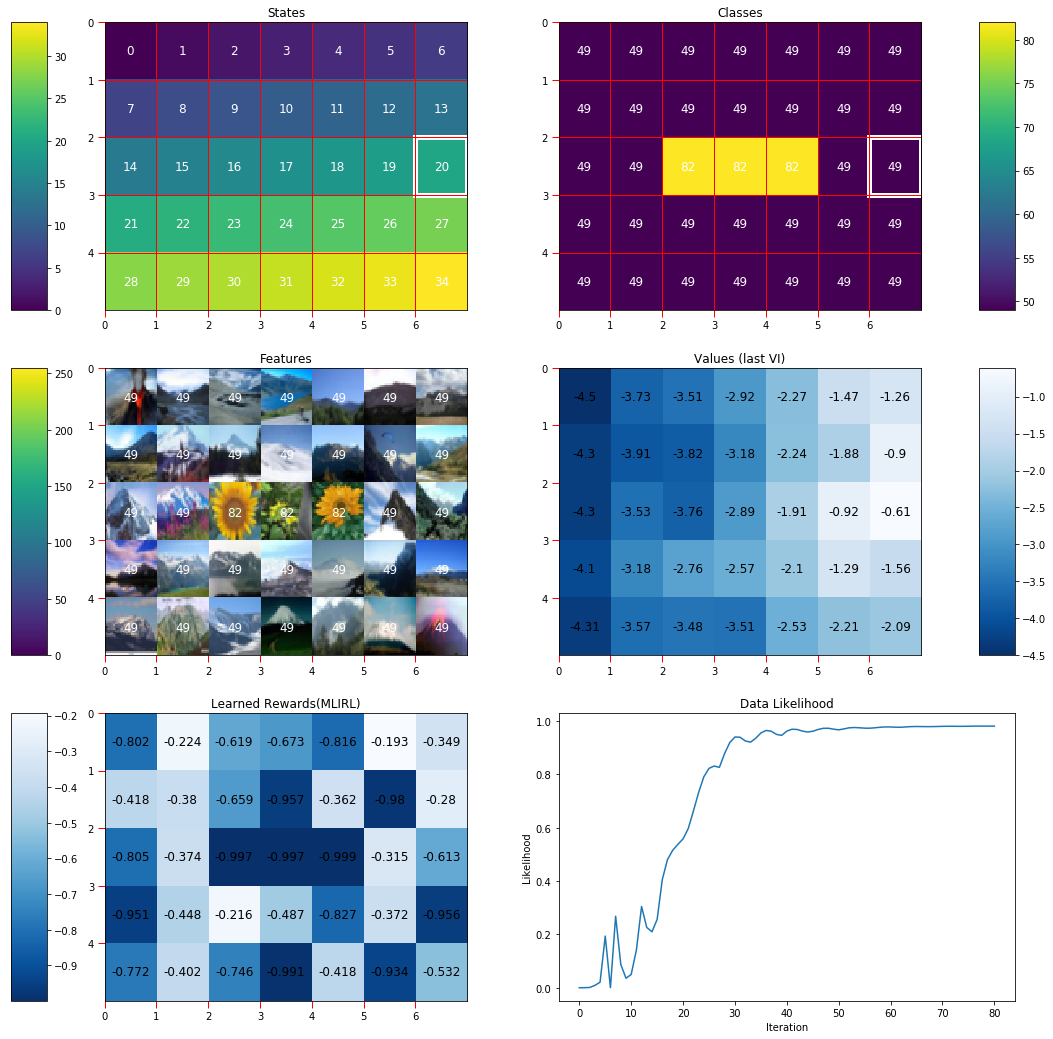

In [8]:
plt.figure(figsize=(18,18))
plt.subplot(3,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(3,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(3,2,3)
NvPlotter(S).plot_features(
    ann_col="white", cmap=cm.viridis).colorbar(where="left", pad=.8, size="10%")
plt.subplot(3,2,4)
NvPlotter(S).plot_array(VI.V.detach().numpy().round(2),
                           cmap=cm.Blues_r, title="Values (last VI)").colorbar(where="right", pad=0.8, size="10%")
plt.subplot(3,2,5)
NvPlotter(S).plot_array(R_model(PHI).detach().numpy().round(3), 
                           cmap=cm.Blues_r, title="Learned Rewards(MLIRL)").colorbar(where="left", pad=0.8, size="10%")
plt.subplot(3,2,6)
plt.plot(range(len(log_likelihoods_history)), log_likelihoods_history)
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.title("Data Likelihood")
plt.savefig("./figures/mlirl_gw_5x7_cifar100_images__traj_2_turns")

**Problems:**
Doesn't always work. Finds and gets stuck on a degenerate solution (R = 0 everywhere).

## Using DiscreteLfDWorld2D
(high level API)

In [9]:
s_lst_lst = [[(2,0), (2,1), (1,1), (1,2), (1,3), (1,4), (1,5), (2,5), (2,6)], 
            [(2,0), (2,1), (3,1), (3,2), (3,3), (3,4), (3,5), (2,5), (2,6)]]

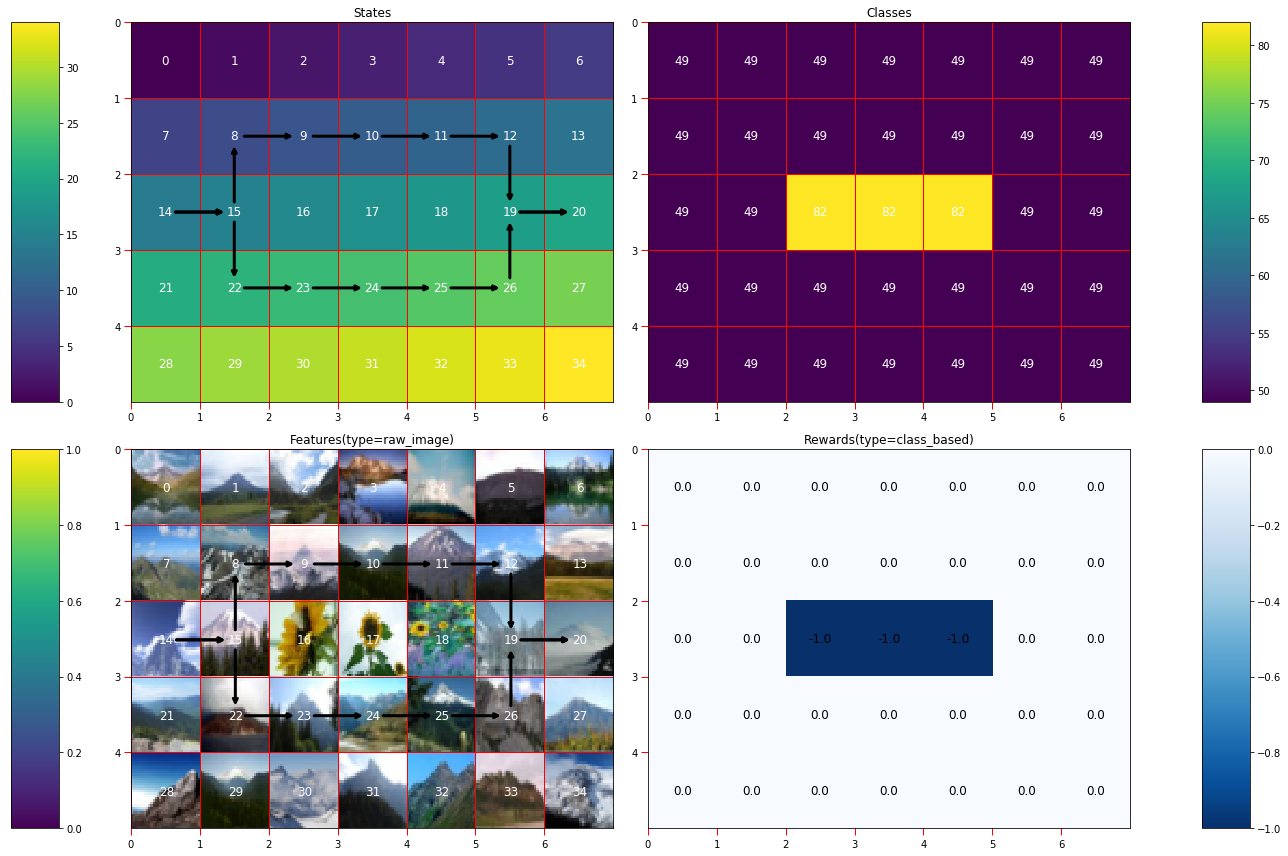

In [10]:
r_model_cnn = RewardConvFCAE(
    (3,32,32), fc1_in=1024, lr=0.005, weight_decay=0.)
phi_spec_cifar100_rgb = NvMDP.features.FeatureClassImageSampler(
    lambda x: sample_image(X, y, x) / 255., 
    key="raw_image")
r_spec_const = NvMDP.reward.RewardStateScalar(
    loc_to_reward_dict={(2,6): 0.}, 
    class_id_to_reward_dict={82: -1}, default=0, 
    key="class_based", feature_key=None)
r_spec_feature_model = NvMDP.reward.RewardStateFeatureModel(
    r_model_cnn, 
    lambda x: torch.FloatTensor(x).unsqueeze(0).permute(0,3,1,2), lambda x: x.squeeze(),
    key="CNN(phi(s))", feature_key="raw_image")

lfdw = NvMDP.world.DiscreteLfDWorld2D(
            discrete_state_space = NvMDP.state.DiscreteStateSpace(5,7),
            class_ids = NvMDP.class_.XYClassDistribution([
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0]], 
                marker_to_class_id = {0: 49, 1: 82})().flatten(),
            phi_spec = [phi_spec_cifar100_rgb],
            r_spec = [r_spec_const, r_spec_feature_model],
            s_lst_lst = s_lst_lst,
            a_lst_lst = None
        )
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="class_based", phi_key="raw_image")

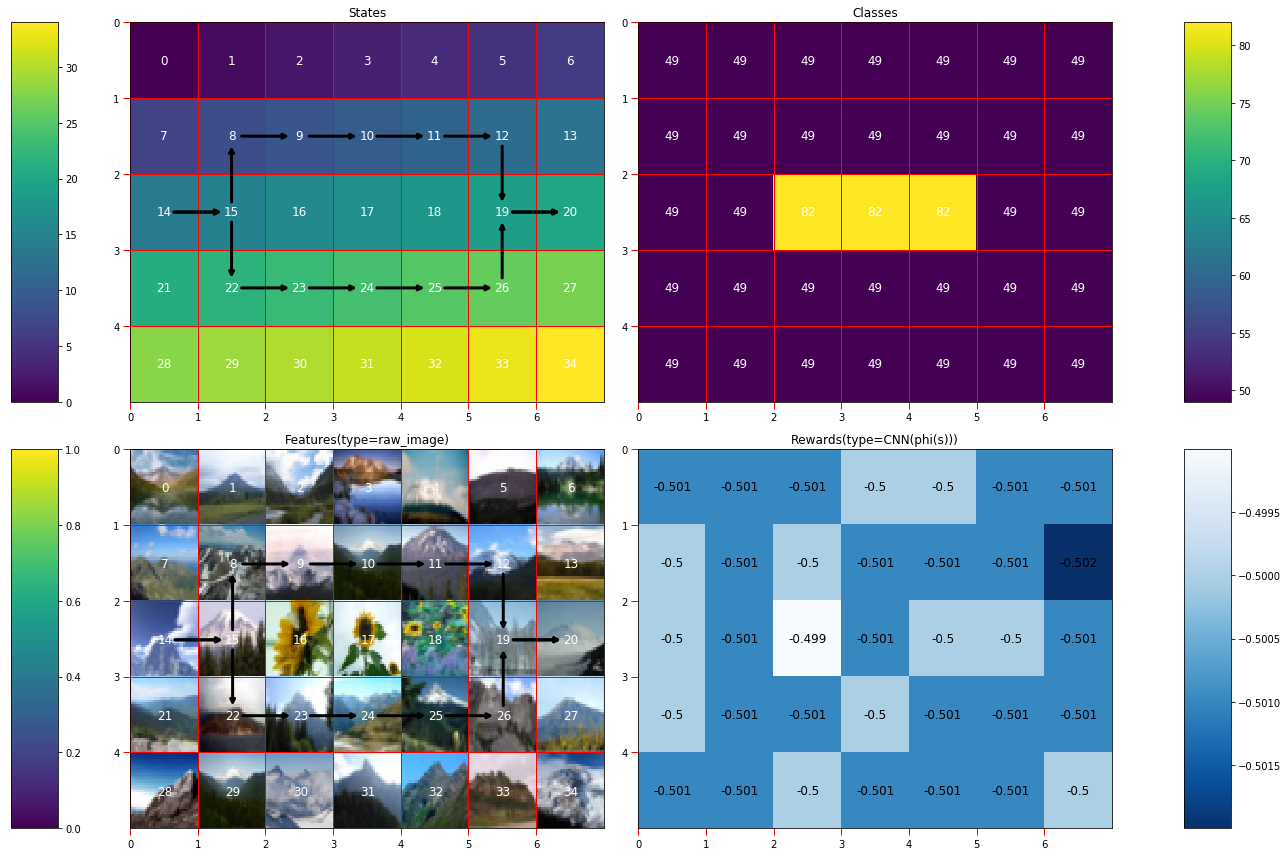

In [11]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="CNN(phi(s))", phi_key="raw_image")

In [18]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = torch.FloatTensor(lfdw.features(numpyize=False)).permute(0,3,1,2), 
    T = lfdw.dynamics(),
    R_model = r_model_cnn,
    gamma=0.99,
    mlirl_iters = 80,
    vi_max_iters = 100,
    reasoning_iters = 50,
    boltzmann_temp = 0.1,
    vi_eps=1e-6
)

Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 17.
Reasoning [  17 47 66 ] Done (50 iters).
>>> Iter: 0000 (0.986s): loss = 01.426067, likelihood = 0.2403


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 17.
Reasoning [  17 47 66 ] Done (50 iters).
>>> Iter: 0001 (1.090s): loss = 01.430728, likelihood = 0.2391


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 17.
Reasoning [  17 47 66 ] Done (50 iters).
>>> Iter: 0002 (1.047s): loss = 01.429988, likelihood = 0.2393


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 17.
Reasoning [  17 47 66 ] Done (50 iters).
>>> Iter: 0003 (1.049s): loss = 01.424708, likelihood = 0.2406


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 17.
Reasoning [  17 47 66 ] Done (50 iters).
>>> Iter: 0004 (1.067s): loss = 01.423513, likelihood = 0.2409


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 18.
Reasoning [  18 48 67 ] Done (50 iters).
>>> Iter: 0005 (1.076s): loss = 01.4272

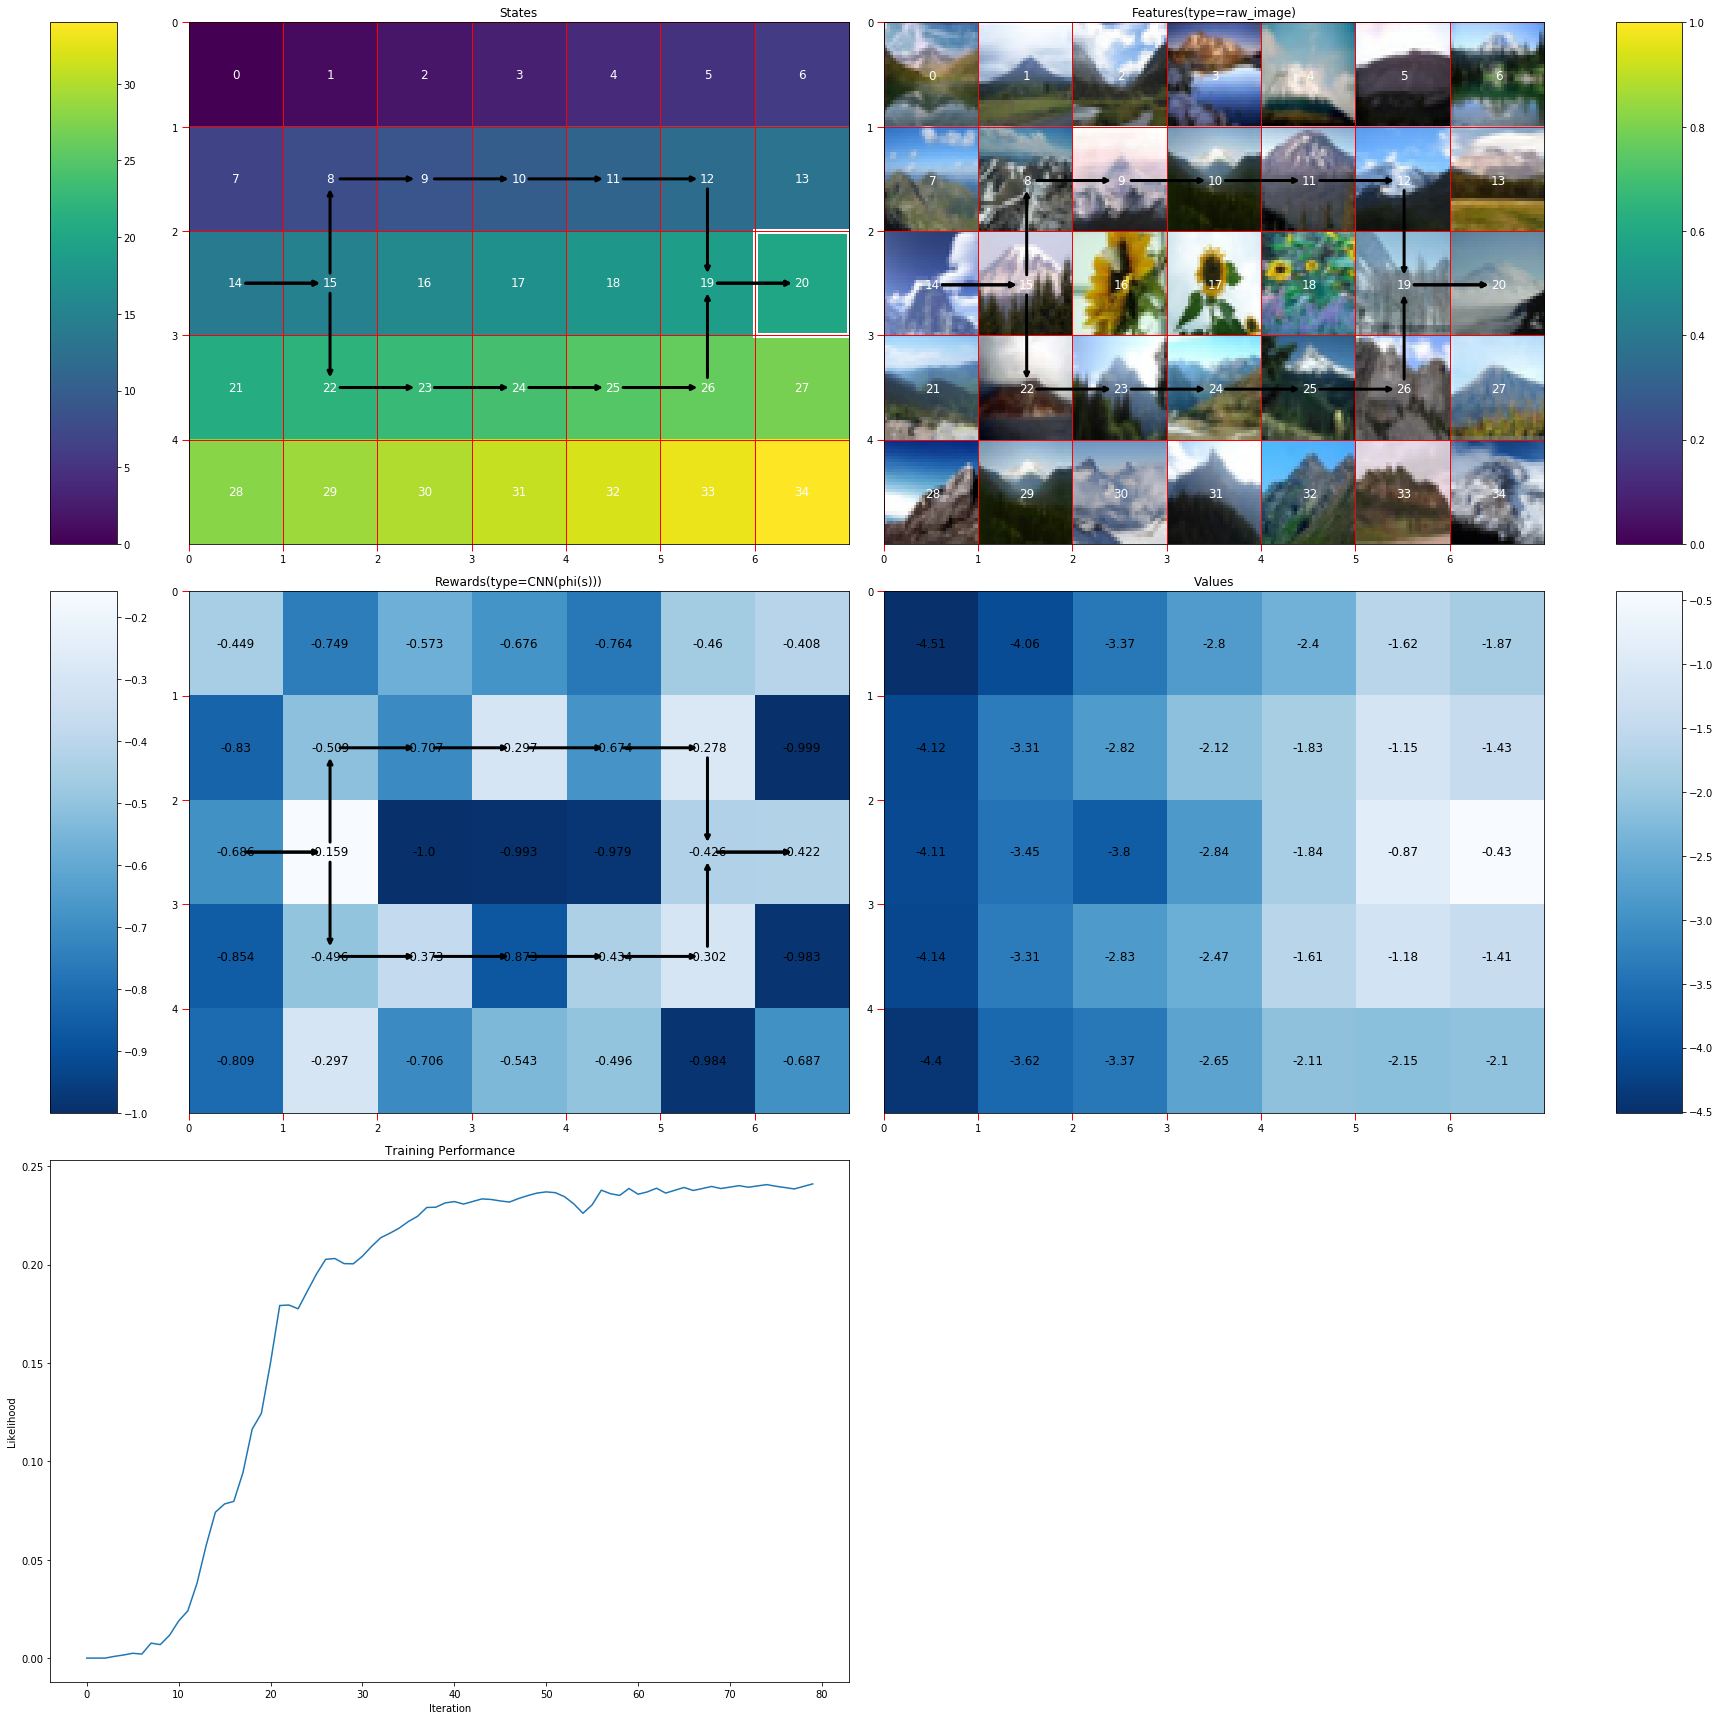

In [14]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="CNN(phi(s))", phi_key="raw_image")
# plt.savefig("./figures/mlirl_lfdw_5x7_cifar100_images__traj_2_turns")

## TODO: fix reampling features problem

In [ ]:
# # Using torch.tensor instead won't preserve the graph and produce desired gradients.
# r = torch.stack(lfdw.rewards(key="f2", numpyize=False)) 
# r_model = lfdw.S[0].reward_spec_dict["f2"].r_model